# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 100, 100, 100, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 100, 100, 100, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8844
Epoch 1/200, Iteration 2/12, Loss: 0.4781
Epoch 1/200, Iteration 3/12, Loss: 0.4533
Epoch 1/200, Iteration 4/12, Loss: 0.4386
Epoch 1/200, Iteration 5/12, Loss: 0.3681
Epoch 1/200, Iteration 6/12, Loss: 0.3286
Epoch 1/200, Iteration 7/12, Loss: 0.3308
Epoch 1/200, Iteration 8/12, Loss: 0.3581
Epoch 1/200, Iteration 9/12, Loss: 0.3739
Epoch 1/200, Iteration 10/12, Loss: 0.2932
Epoch 1/200, Iteration 11/12, Loss: 0.2356
Epoch 1/200, Iteration 12/12, Loss: 0.2500
Epoch 1/200, Iteration 13/12, Loss: 0.2571
Train Error: 
 Accuracy: 53.0%, Avg loss: 0.299972, MRE: 0.218428, MAE: 0.039492 

Test Error: 
 Accuracy: 55.5%, Avg loss: 0.287881, MRE: 0.195759, MAE: 0.036781 

Epoch 2/200, Iteration 1/12, Loss: 0.3167
Epoch 2/200, Iteration 2/12, Loss: 0.2585
Epoch 2/200, Iteration 3/12, Loss: 0.2589
Epoch 2/200, Iteration 4/12, Loss: 0.3123
Epoch 2/200, Iteration 5/12, Loss: 0.2480
Epoch 2/200, Iteration 6/12, Loss: 0.2512
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 77.75%, Avg loss: 0.082131, MRE: 0.064156, MAE: 0.010761 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.078456, MRE: 0.054433, MAE: 0.010463 

Epoch 13/200, Iteration 1/12, Loss: 0.0757
Epoch 13/200, Iteration 2/12, Loss: 0.0848
Epoch 13/200, Iteration 3/12, Loss: 0.0830
Epoch 13/200, Iteration 4/12, Loss: 0.0652
Epoch 13/200, Iteration 5/12, Loss: 0.0561
Epoch 13/200, Iteration 6/12, Loss: 0.0759
Epoch 13/200, Iteration 7/12, Loss: 0.0637
Epoch 13/200, Iteration 8/12, Loss: 0.0710
Epoch 13/200, Iteration 9/12, Loss: 0.0594
Epoch 13/200, Iteration 10/12, Loss: 0.0968
Epoch 13/200, Iteration 11/12, Loss: 0.0768
Epoch 13/200, Iteration 12/12, Loss: 0.0843
Epoch 13/200, Iteration 13/12, Loss: 0.0791
Train Error: 
 Accuracy: 95.0%, Avg loss: 0.075508, MRE: 0.062188, MAE: 0.010281 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.068188, MRE: 0.041770, MAE: 0.009642 

Epoch 14/200, Iteration 1/12, Loss: 0.0778
Epoch 14/200, Iteration 2/12, Loss: 0.0770
Epoch 14/200, Iterat

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.087528, MRE: 0.068248, MAE: 0.010984 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.092332, MRE: 0.057697, MAE: 0.011129 

Epoch 25/200, Iteration 1/12, Loss: 0.0916
Epoch 25/200, Iteration 2/12, Loss: 0.0830
Epoch 25/200, Iteration 3/12, Loss: 0.0652
Epoch 25/200, Iteration 4/12, Loss: 0.0598
Epoch 25/200, Iteration 5/12, Loss: 0.0601
Epoch 25/200, Iteration 6/12, Loss: 0.0849
Epoch 25/200, Iteration 7/12, Loss: 0.0804
Epoch 25/200, Iteration 8/12, Loss: 0.0586
Epoch 25/200, Iteration 9/12, Loss: 0.0849
Epoch 25/200, Iteration 10/12, Loss: 0.0714
Epoch 25/200, Iteration 11/12, Loss: 0.0510
Epoch 25/200, Iteration 12/12, Loss: 0.0657
Epoch 25/200, Iteration 13/12, Loss: 0.0488
Train Error: 
 Accuracy: 89.0%, Avg loss: 0.066404, MRE: 0.059344, MAE: 0.008691 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.061833, MRE: 0.047881, MAE: 0.007987 

Epoch 26/200, Iteration 1/12, Loss: 0.0596
Epoch 26/200, Iteration 2/12, Loss: 0.0739
Epoch 26/200, Iterati

Epoch 36/200, Iteration 4/12, Loss: 0.0150
Epoch 36/200, Iteration 5/12, Loss: 0.0165
Epoch 36/200, Iteration 6/12, Loss: 0.0133
Epoch 36/200, Iteration 7/12, Loss: 0.0197
Epoch 36/200, Iteration 8/12, Loss: 0.0166
Epoch 36/200, Iteration 9/12, Loss: 0.0118
Epoch 36/200, Iteration 10/12, Loss: 0.0163
Epoch 36/200, Iteration 11/12, Loss: 0.0187
Epoch 36/200, Iteration 12/12, Loss: 0.0162
Epoch 36/200, Iteration 13/12, Loss: 0.0179
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.015641, MRE: 0.017548, MAE: 0.002065 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014973, MRE: 0.011372, MAE: 0.001917 

Epoch 37/200, Iteration 1/12, Loss: 0.0135
Epoch 37/200, Iteration 2/12, Loss: 0.0147
Epoch 37/200, Iteration 3/12, Loss: 0.0144
Epoch 37/200, Iteration 4/12, Loss: 0.0140
Epoch 37/200, Iteration 5/12, Loss: 0.0132
Epoch 37/200, Iteration 6/12, Loss: 0.0139
Epoch 37/200, Iteration 7/12, Loss: 0.0149
Epoch 37/200, Iteration 8/12, Loss: 0.0219
Epoch 37/200, Iteration 9/12, Loss: 0.0183
Epoch 37/200, 

Epoch 47/200, Iteration 13/12, Loss: 0.0109
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.011749, MRE: 0.012721, MAE: 0.001538 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011318, MRE: 0.008913, MAE: 0.001482 

Epoch 48/200, Iteration 1/12, Loss: 0.0118
Epoch 48/200, Iteration 2/12, Loss: 0.0164
Epoch 48/200, Iteration 3/12, Loss: 0.0138
Epoch 48/200, Iteration 4/12, Loss: 0.0103
Epoch 48/200, Iteration 5/12, Loss: 0.0145
Epoch 48/200, Iteration 6/12, Loss: 0.0127
Epoch 48/200, Iteration 7/12, Loss: 0.0138
Epoch 48/200, Iteration 8/12, Loss: 0.0098
Epoch 48/200, Iteration 9/12, Loss: 0.0152
Epoch 48/200, Iteration 10/12, Loss: 0.0183
Epoch 48/200, Iteration 11/12, Loss: 0.0110
Epoch 48/200, Iteration 12/12, Loss: 0.0133
Epoch 48/200, Iteration 13/12, Loss: 0.0141
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.013912, MRE: 0.013940, MAE: 0.001803 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013518, MRE: 0.010406, MAE: 0.001702 

Epoch 49/200, Iteration 1/12, Loss: 0.0127
Epoch 49/200, Iter

Epoch 59/200, Iteration 11/12, Loss: 0.0098
Epoch 59/200, Iteration 12/12, Loss: 0.0128
Epoch 59/200, Iteration 13/12, Loss: 0.0107
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.011433, MRE: 0.011528, MAE: 0.001532 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010441, MRE: 0.008099, MAE: 0.001351 

Epoch 60/200, Iteration 1/12, Loss: 0.0161
Epoch 60/200, Iteration 2/12, Loss: 0.0093
Epoch 60/200, Iteration 3/12, Loss: 0.0097
Epoch 60/200, Iteration 4/12, Loss: 0.0098
Epoch 60/200, Iteration 5/12, Loss: 0.0113
Epoch 60/200, Iteration 6/12, Loss: 0.0151
Epoch 60/200, Iteration 7/12, Loss: 0.0111
Epoch 60/200, Iteration 8/12, Loss: 0.0113
Epoch 60/200, Iteration 9/12, Loss: 0.0141
Epoch 60/200, Iteration 10/12, Loss: 0.0135
Epoch 60/200, Iteration 11/12, Loss: 0.0140
Epoch 60/200, Iteration 12/12, Loss: 0.0127
Epoch 60/200, Iteration 13/12, Loss: 0.0118
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.012383, MRE: 0.011978, MAE: 0.001508 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011424, MRE: 

Epoch 71/200, Iteration 6/12, Loss: 0.0083
Epoch 71/200, Iteration 7/12, Loss: 0.0097
Epoch 71/200, Iteration 8/12, Loss: 0.0085
Epoch 71/200, Iteration 9/12, Loss: 0.0047
Epoch 71/200, Iteration 10/12, Loss: 0.0070
Epoch 71/200, Iteration 11/12, Loss: 0.0070
Epoch 71/200, Iteration 12/12, Loss: 0.0067
Epoch 71/200, Iteration 13/12, Loss: 0.0069
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007081, MRE: 0.008532, MAE: 0.000919 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007137, MRE: 0.006227, MAE: 0.000905 

Epoch 72/200, Iteration 1/12, Loss: 0.0081
Epoch 72/200, Iteration 2/12, Loss: 0.0063
Epoch 72/200, Iteration 3/12, Loss: 0.0062
Epoch 72/200, Iteration 4/12, Loss: 0.0067
Epoch 72/200, Iteration 5/12, Loss: 0.0085
Epoch 72/200, Iteration 6/12, Loss: 0.0096
Epoch 72/200, Iteration 7/12, Loss: 0.0094
Epoch 72/200, Iteration 8/12, Loss: 0.0068
Epoch 72/200, Iteration 9/12, Loss: 0.0051
Epoch 72/200, Iteration 10/12, Loss: 0.0076
Epoch 72/200, Iteration 11/12, Loss: 0.0065
Epoch 72/20

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007254, MRE: 0.009100, MAE: 0.000932 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007459, MRE: 0.006399, MAE: 0.000935 

Epoch 83/200, Iteration 1/12, Loss: 0.0065
Epoch 83/200, Iteration 2/12, Loss: 0.0081
Epoch 83/200, Iteration 3/12, Loss: 0.0077
Epoch 83/200, Iteration 4/12, Loss: 0.0077
Epoch 83/200, Iteration 5/12, Loss: 0.0054
Epoch 83/200, Iteration 6/12, Loss: 0.0054
Epoch 83/200, Iteration 7/12, Loss: 0.0099
Epoch 83/200, Iteration 8/12, Loss: 0.0095
Epoch 83/200, Iteration 9/12, Loss: 0.0061
Epoch 83/200, Iteration 10/12, Loss: 0.0055
Epoch 83/200, Iteration 11/12, Loss: 0.0061
Epoch 83/200, Iteration 12/12, Loss: 0.0079
Epoch 83/200, Iteration 13/12, Loss: 0.0060
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007294, MRE: 0.008560, MAE: 0.000969 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007455, MRE: 0.006411, MAE: 0.000966 

Epoch 84/200, Iteration 1/12, Loss: 0.0076
Epoch 84/200, Iteration 2/12, Loss: 0.0104
Epoch 84/200, Itera

Epoch 94/200, Iteration 13/12, Loss: 0.0059
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007444, MRE: 0.008946, MAE: 0.000969 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007485, MRE: 0.006593, MAE: 0.000960 

Epoch 95/200, Iteration 1/12, Loss: 0.0070
Epoch 95/200, Iteration 2/12, Loss: 0.0069
Epoch 95/200, Iteration 3/12, Loss: 0.0075
Epoch 95/200, Iteration 4/12, Loss: 0.0098
Epoch 95/200, Iteration 5/12, Loss: 0.0083
Epoch 95/200, Iteration 6/12, Loss: 0.0069
Epoch 95/200, Iteration 7/12, Loss: 0.0076
Epoch 95/200, Iteration 8/12, Loss: 0.0059
Epoch 95/200, Iteration 9/12, Loss: 0.0087
Epoch 95/200, Iteration 10/12, Loss: 0.0053
Epoch 95/200, Iteration 11/12, Loss: 0.0052
Epoch 95/200, Iteration 12/12, Loss: 0.0076
Epoch 95/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.006869, MRE: 0.008386, MAE: 0.000902 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006949, MRE: 0.006034, MAE: 0.000892 

Epoch 96/200, Iteration 1/12, Loss: 0.0100
Epoch 96/200, Iter

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006822, MRE: 0.005931, MAE: 0.000862 

Epoch 106/200, Iteration 1/12, Loss: 0.0081
Epoch 106/200, Iteration 2/12, Loss: 0.0080
Epoch 106/200, Iteration 3/12, Loss: 0.0108
Epoch 106/200, Iteration 4/12, Loss: 0.0057
Epoch 106/200, Iteration 5/12, Loss: 0.0072
Epoch 106/200, Iteration 6/12, Loss: 0.0053
Epoch 106/200, Iteration 7/12, Loss: 0.0067
Epoch 106/200, Iteration 8/12, Loss: 0.0051
Epoch 106/200, Iteration 9/12, Loss: 0.0062
Epoch 106/200, Iteration 10/12, Loss: 0.0040
Epoch 106/200, Iteration 11/12, Loss: 0.0074
Epoch 106/200, Iteration 12/12, Loss: 0.0059
Epoch 106/200, Iteration 13/12, Loss: 0.0050
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.006648, MRE: 0.007813, MAE: 0.000863 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007024, MRE: 0.006102, MAE: 0.000898 

Epoch 107/200, Iteration 1/12, Loss: 0.0056
Epoch 107/200, Iteration 2/12, Loss: 0.0073
Epoch 107/200, Iteration 3/12, Loss: 0.0087
Epoch 107/200, Iteration 4/12, Loss: 0.0070

Epoch 117/200, Iteration 7/12, Loss: 0.0075
Epoch 117/200, Iteration 8/12, Loss: 0.0064
Epoch 117/200, Iteration 9/12, Loss: 0.0069
Epoch 117/200, Iteration 10/12, Loss: 0.0066
Epoch 117/200, Iteration 11/12, Loss: 0.0103
Epoch 117/200, Iteration 12/12, Loss: 0.0047
Epoch 117/200, Iteration 13/12, Loss: 0.0110
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.006575, MRE: 0.007484, MAE: 0.000856 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006517, MRE: 0.005847, MAE: 0.000816 

Epoch 118/200, Iteration 1/12, Loss: 0.0081
Epoch 118/200, Iteration 2/12, Loss: 0.0049
Epoch 118/200, Iteration 3/12, Loss: 0.0059
Epoch 118/200, Iteration 4/12, Loss: 0.0103
Epoch 118/200, Iteration 5/12, Loss: 0.0093
Epoch 118/200, Iteration 6/12, Loss: 0.0063
Epoch 118/200, Iteration 7/12, Loss: 0.0073
Epoch 118/200, Iteration 8/12, Loss: 0.0055
Epoch 118/200, Iteration 9/12, Loss: 0.0056
Epoch 118/200, Iteration 10/12, Loss: 0.0055
Epoch 118/200, Iteration 11/12, Loss: 0.0061
Epoch 118/200, Iteration 12/12, Los

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.006061, MRE: 0.007129, MAE: 0.000791 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006280, MRE: 0.005606, MAE: 0.000802 

Epoch 129/200, Iteration 1/12, Loss: 0.0088
Epoch 129/200, Iteration 2/12, Loss: 0.0059
Epoch 129/200, Iteration 3/12, Loss: 0.0044
Epoch 129/200, Iteration 4/12, Loss: 0.0050
Epoch 129/200, Iteration 5/12, Loss: 0.0076
Epoch 129/200, Iteration 6/12, Loss: 0.0058
Epoch 129/200, Iteration 7/12, Loss: 0.0050
Epoch 129/200, Iteration 8/12, Loss: 0.0058
Epoch 129/200, Iteration 9/12, Loss: 0.0050
Epoch 129/200, Iteration 10/12, Loss: 0.0052
Epoch 129/200, Iteration 11/12, Loss: 0.0077
Epoch 129/200, Iteration 12/12, Loss: 0.0067
Epoch 129/200, Iteration 13/12, Loss: 0.0105
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.006220, MRE: 0.007198, MAE: 0.000806 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006378, MRE: 0.005658, MAE: 0.000796 

Epoch 130/200, Iteration 1/12, Loss: 0.0055
Epoch 130/200, Iteration 2/12, Loss: 0.0063
Epo

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006058, MRE: 0.005482, MAE: 0.000761 

Epoch 141/200, Iteration 1/12, Loss: 0.0044
Epoch 141/200, Iteration 2/12, Loss: 0.0059
Epoch 141/200, Iteration 3/12, Loss: 0.0057
Epoch 141/200, Iteration 4/12, Loss: 0.0091
Epoch 141/200, Iteration 5/12, Loss: 0.0065
Epoch 141/200, Iteration 6/12, Loss: 0.0043
Epoch 141/200, Iteration 7/12, Loss: 0.0037
Epoch 141/200, Iteration 8/12, Loss: 0.0061
Epoch 141/200, Iteration 9/12, Loss: 0.0070
Epoch 141/200, Iteration 10/12, Loss: 0.0082
Epoch 141/200, Iteration 11/12, Loss: 0.0062
Epoch 141/200, Iteration 12/12, Loss: 0.0040
Epoch 141/200, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005731, MRE: 0.006677, MAE: 0.000745 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006034, MRE: 0.005424, MAE: 0.000764 

Epoch 142/200, Iteration 1/12, Loss: 0.0049
Epoch 142/200, Iteration 2/12, Loss: 0.0045
Epoch 142/200, Iteration 3/12, Loss: 0.0053
Epoch 142/200, Iteration 4/12, Loss: 0.006

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005672, MRE: 0.006634, MAE: 0.000739 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006038, MRE: 0.005420, MAE: 0.000763 

Epoch 153/200, Iteration 1/12, Loss: 0.0063
Epoch 153/200, Iteration 2/12, Loss: 0.0061
Epoch 153/200, Iteration 3/12, Loss: 0.0068
Epoch 153/200, Iteration 4/12, Loss: 0.0061
Epoch 153/200, Iteration 5/12, Loss: 0.0050
Epoch 153/200, Iteration 6/12, Loss: 0.0055
Epoch 153/200, Iteration 7/12, Loss: 0.0051
Epoch 153/200, Iteration 8/12, Loss: 0.0076
Epoch 153/200, Iteration 9/12, Loss: 0.0056
Epoch 153/200, Iteration 10/12, Loss: 0.0047
Epoch 153/200, Iteration 11/12, Loss: 0.0040
Epoch 153/200, Iteration 12/12, Loss: 0.0079
Epoch 153/200, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005653, MRE: 0.006556, MAE: 0.000739 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006062, MRE: 0.005428, MAE: 0.000767 

Epoch 154/200, Iteration 1/12, Loss: 0.0066
Epoch 154/200, Iteration 2/12, Loss: 0.0051
Ep

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005637, MRE: 0.006533, MAE: 0.000735 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006057, MRE: 0.005420, MAE: 0.000767 

Epoch 165/200, Iteration 1/12, Loss: 0.0046
Epoch 165/200, Iteration 2/12, Loss: 0.0067
Epoch 165/200, Iteration 3/12, Loss: 0.0083
Epoch 165/200, Iteration 4/12, Loss: 0.0046
Epoch 165/200, Iteration 5/12, Loss: 0.0064
Epoch 165/200, Iteration 6/12, Loss: 0.0050
Epoch 165/200, Iteration 7/12, Loss: 0.0058
Epoch 165/200, Iteration 8/12, Loss: 0.0059
Epoch 165/200, Iteration 9/12, Loss: 0.0045
Epoch 165/200, Iteration 10/12, Loss: 0.0062
Epoch 165/200, Iteration 11/12, Loss: 0.0041
Epoch 165/200, Iteration 12/12, Loss: 0.0070
Epoch 165/200, Iteration 13/12, Loss: 0.0043
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005729, MRE: 0.006688, MAE: 0.000747 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006060, MRE: 0.005420, MAE: 0.000767 

Epoch 166/200, Iteration 1/12, Loss: 0.0042
Epoch 166/200, Iteration 2/12, Loss: 0.0055
Ep

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005609, MRE: 0.006603, MAE: 0.000733 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006057, MRE: 0.005415, MAE: 0.000767 

Epoch 177/200, Iteration 1/12, Loss: 0.0044
Epoch 177/200, Iteration 2/12, Loss: 0.0059
Epoch 177/200, Iteration 3/12, Loss: 0.0047
Epoch 177/200, Iteration 4/12, Loss: 0.0052
Epoch 177/200, Iteration 5/12, Loss: 0.0049
Epoch 177/200, Iteration 6/12, Loss: 0.0049
Epoch 177/200, Iteration 7/12, Loss: 0.0050
Epoch 177/200, Iteration 8/12, Loss: 0.0074
Epoch 177/200, Iteration 9/12, Loss: 0.0077
Epoch 177/200, Iteration 10/12, Loss: 0.0037
Epoch 177/200, Iteration 11/12, Loss: 0.0064
Epoch 177/200, Iteration 12/12, Loss: 0.0078
Epoch 177/200, Iteration 13/12, Loss: 0.0063
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005796, MRE: 0.006743, MAE: 0.000756 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006060, MRE: 0.005417, MAE: 0.000767 

Epoch 178/200, Iteration 1/12, Loss: 0.0049
Epoch 178/200, Iteration 2/12, Loss: 0.0060
Ep

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005767, MRE: 0.006604, MAE: 0.000749 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006061, MRE: 0.005418, MAE: 0.000768 

Epoch 189/200, Iteration 1/12, Loss: 0.0086
Epoch 189/200, Iteration 2/12, Loss: 0.0047
Epoch 189/200, Iteration 3/12, Loss: 0.0048
Epoch 189/200, Iteration 4/12, Loss: 0.0067
Epoch 189/200, Iteration 5/12, Loss: 0.0060
Epoch 189/200, Iteration 6/12, Loss: 0.0064
Epoch 189/200, Iteration 7/12, Loss: 0.0049
Epoch 189/200, Iteration 8/12, Loss: 0.0037
Epoch 189/200, Iteration 9/12, Loss: 0.0062
Epoch 189/200, Iteration 10/12, Loss: 0.0045
Epoch 189/200, Iteration 11/12, Loss: 0.0067
Epoch 189/200, Iteration 12/12, Loss: 0.0046
Epoch 189/200, Iteration 13/12, Loss: 0.0068
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005656, MRE: 0.006504, MAE: 0.000737 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006061, MRE: 0.005418, MAE: 0.000768 

Epoch 190/200, Iteration 1/12, Loss: 0.0052
Epoch 190/200, Iteration 2/12, Loss: 0.0065
Ep

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005616, MRE: 0.006507, MAE: 0.000733 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006061, MRE: 0.005418, MAE: 0.000767 



#### Plots loss vs Epoch

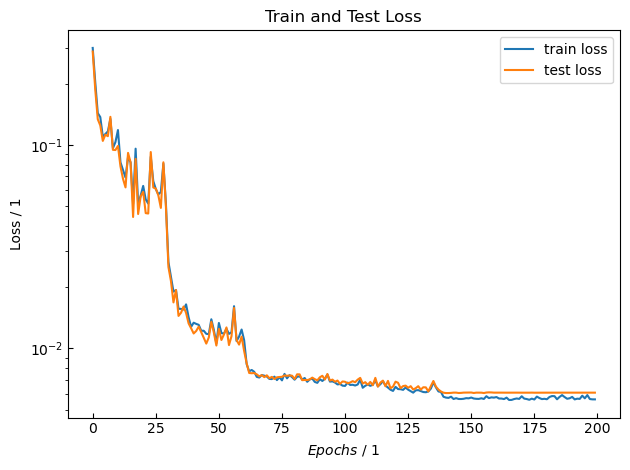

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Speichern der Trainingskurve

In [11]:
np.savez('data/models/hyperparams/loss_005_003.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998332660104725 , R^2(NH3) = 0.9996718754751828
Test Dataset: R^2(H2) = 0.9999379396268108 , R^2(NH3) = 0.9998247518169733
Max Error Training: |x_H2 - x_H2,pred| = 0.05026247392805866 , |x_NH3 - x_NH3,pred| = 0.024758004530748973
Max Error Test: |x_H2 - x_H2,pred| = 0.005753126268466746 , |x_NH3 - x_NH3,pred| = 0.009419216335346259


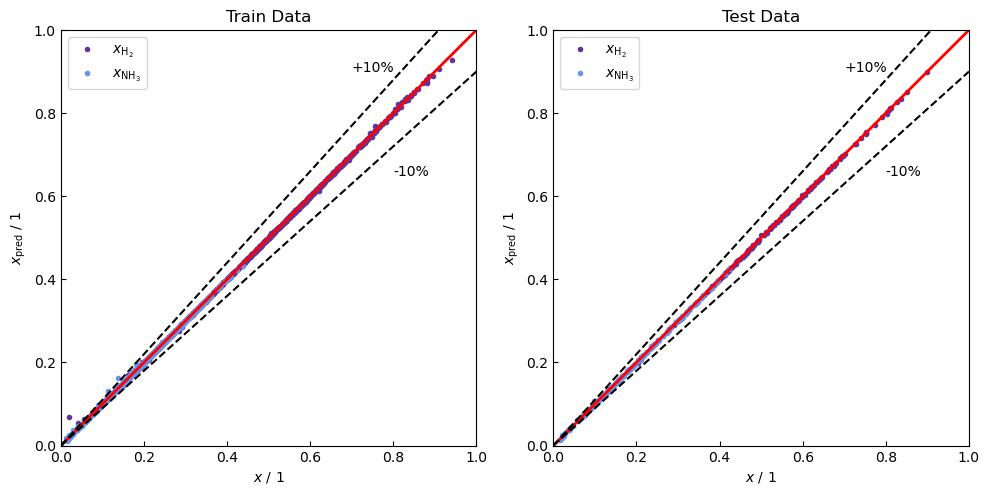

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

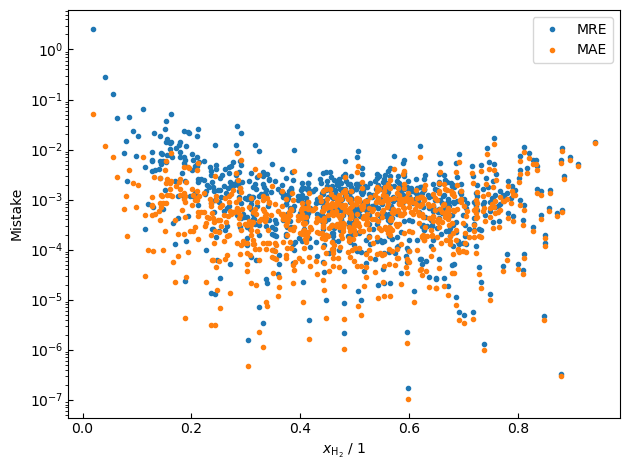

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

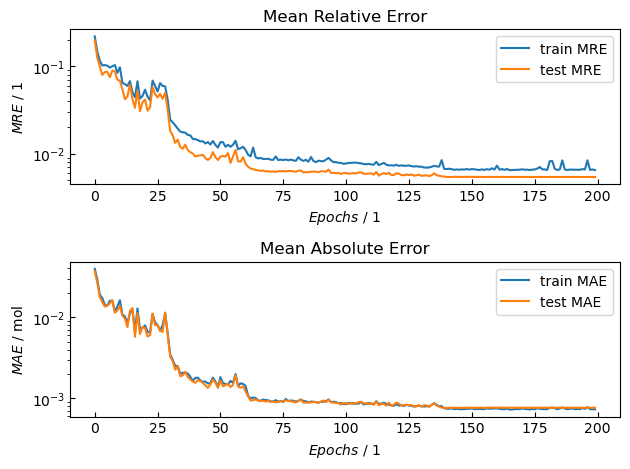

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

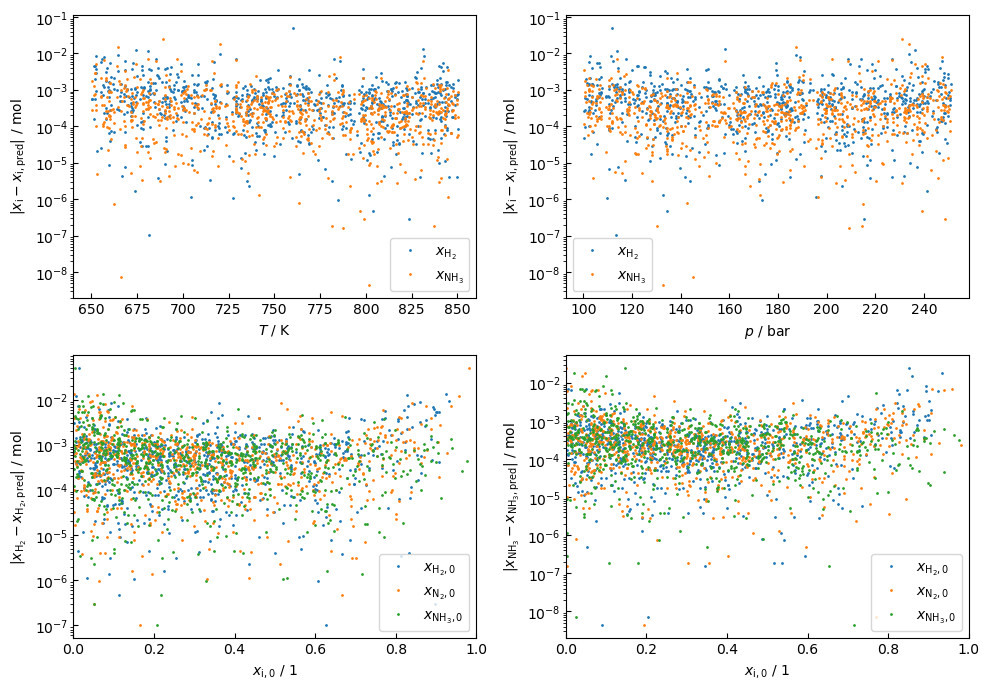

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

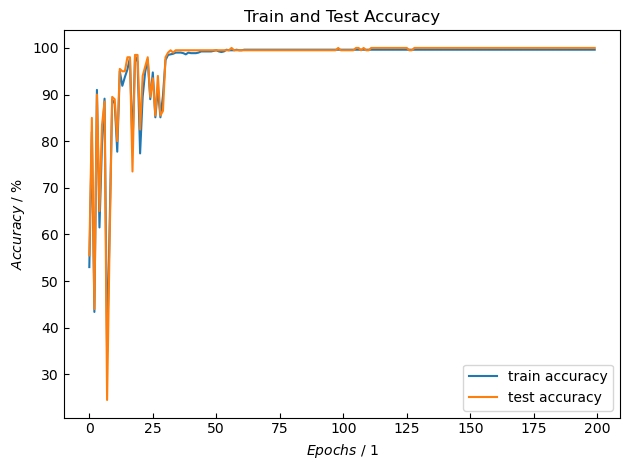

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 1.1288,  1.0831, -0.2996, -0.3538,  0.6557],
        [ 1.5276,  0.1648, -0.0329, -0.7492,  0.7981],
        [-0.5446,  0.4824, -0.2008, -0.7768,  0.9910],
        [ 0.5370,  0.8201,  0.4321, -0.2713, -0.1468],
        [ 0.2337,  0.5307, -0.5686,  1.6161, -1.0938],
        [ 0.3890, -1.1354,  0.8459, -1.0446,  0.2375],
        [ 1.2370,  1.4823,  2.2752, -0.9064, -1.3064],
        [-0.8378, -1.4711, -1.1141, -0.9800,  2.0950],
        [ 1.0638,  1.7039,  0.1009,  1.0575, -1.1799],
        [ 1.5870,  1.2557, -0.4148, -0.3719,  0.7872],
        [-0.7281, -1.4142,  0.2481,  0.6148, -0.8719],
        [-0.9084, -1.2030,  1.6249, -0.5641, -1.0180],
        [ 0.3260,  0.6215,  2.3266, -1.3453, -0.9083],
        [-1.3038, -1.5498, -1.2927, -0.6445,  1.9273],
        [-0.0369, -1.5949, -0.0789, -1.1470,  1.2498],
        [-1.2668,  0.1841, -0.1153, -0.5726,  0.6984],
        [ 0.6812, -0.9397, -0.9280,  1.6291, -0.7543],
        [ 1.0330, -1.0847, -1.3381,  0.6343,  0.6649],
        [-

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 3.2572e-01,  1.4297e-01,  6.7857e-02,  7.4600e-02,  2.8056e-02],
         [ 1.6292e-01, -7.6062e-02, -6.9062e-02, -2.5843e-01, -1.8471e-01],
         [ 3.3211e-01,  5.0286e-02, -8.2134e-02,  2.4415e-01,  2.5020e-02],
         [ 4.3289e-01,  1.2684e-01, -4.2624e-01,  4.2346e-02,  1.0662e-01],
         [ 1.1380e-01, -1.6818e-03,  1.6257e-01,  2.3647e-01,  2.4783e-01],
         [-2.9310e-01,  2.1449e-01, -2.8023e-01, -4.0956e-02,  9.9468e-03],
         [-4.3483e-02, -1.1146e-01, -1.9795e-01, -1.7850e-01, -1.3716e-01],
         [-1.0692e-02, -1.0977e-01, -5.4837e-02, -1.4214e-04, -1.3712e-01],
         [ 4.3227e-03,  1.4706e-02,  2.7241e-01, -8.4499e-02,  3.6456e-01],
         [ 4.1427e-01, -2.7394e-01,  9.9523e-02, -9.4820e-02, -6.2183e-02],
         [-6.0439e-04,  9.2179e-02,  1.2929e-01, -1.7390e-01,  3.1137e-01],
         [ 1.6417e-01,  1.8808e-02, -2.0729e-01,  2.1740e-01, -5.7391e-02],
         [-3.3849e-01,  4.9580e-01,  2.5212e-01, -4.3256e-01,  5.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1675, 0.2316, 0.9860, 0.9863, 0.5318],
        [0.4269, 0.7678, 0.9875, 0.4453, 0.0349]])
tensor([[ 0.0033, -0.3650],
        [ 0.2254, -0.1484]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.4144,  1.0392,  0.2892, -0.2749, -0.0028],
        [-1.4645, -0.9364,  0.8398, -0.7597, -0.0478],
        [ 1.1035,  0.3839,  0.2508, -1.2986,  1.0812],
        [-1.0639, -0.1890, -1.3405, -0.2066,  1.5268],
        [-0.2379,  0.1820, -0.2512,  0.4214, -0.1842],
        [ 1.4035,  0.5941, -0.6303, -0.9479,  1.5874],
        [ 1.5685,  0.2578,  0.5006, -0.5690,  0.0902],
        [ 1.1586, -0.7642,  0.0174,  0.4298, -0.4564],
        [ 1.0330, -1.0847, -1.3381,  0.6343,  0.6649],
        [-0.7146, -1.0650, -0.5133,  1.4720, -1.0007],
        [ 1.2686,  0.8980, -0.8116,  0.1596,  0.6333],
        [-0.3442,  0.2931, -0.5032,  0.1984,  0.2910],
        [ 0.3820, -1.4799, -0.8625,  1.6130, -0.8021],
        [-0.0088, -0.0926, -1.1977,  1.3595, -0.2142],
        [ 1.3878,  1.3683,  0.6112,  0.3149, -0.9217],
        [ 0.1586,  0.1345, -0.1886, -0.4093,  0.6034],
        [-1.2668,  0.1841, -0.1153, -0.5726,  0.6984],
        [-0.2293, -0.0639, -0.6230,  0.8021, -0.2084],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()